Use this to load Tensorflow modelzoo models from export to run inference and inspect predictions.

First some imports:

In [33]:
import tensorflow as tf
import numpy as np
import os
import time
import matplotlib
from matplotlib import patches, text, patheffects
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont
import io
import image_tools
import sys

Constants

In [34]:
THRESHOLD = 0.1
#MODEL_PATH = 'trained_models/faster_rcnn/saved_model'
#MODEL_PATH = 'trained_models/faster_rcnn_5ksteps_dropout5/saved_model'
MODEL_PATH = 'trained_models/efficientDet_d1/saved_model'
#MODEL_PATH = 
#IMAGE_PATH = "C:/Users/sigur/OneDriveMS/FYS-3741-MASTER/data/data_yoloformat/test/images"
IMAGE_PATH = "C:/Users/Sigurd/OneDriveMS/FYS-3741-MASTER/data/data_yoloformat/test/images"

Load functions

In [35]:
def load_image_to_numpy_array(path):
    """
    Load a single image to numpy array
    """
    img_data = tf.io.gfile.GFile(path, 'rb').read()
    image = Image.open(io.BytesIO(img_data))
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(im_height, im_width, 3).astype(np.uint8)

def apply_threshold(detections, threshold):
    """
    Remove predictions with a lower confidence than a defined threshold
    """
    valid_confidence_scores = detections['detection_scores'][0].numpy()>=threshold
    #valid_confidence_scores = detections['detection_scores'][0].numpy()
    nr_detections = np.count_nonzero(valid_confidence_scores)
    bboxes =  detections['detection_boxes'][0].numpy()[range(nr_detections)]
    classes = detections['detection_classes'][0].numpy()[range(nr_detections)]
    confidence_scores = detections['detection_scores'][0].numpy()[range(nr_detections)]

    return nr_detections, confidence_scores, bboxes, classes

def run_inference(image_np):
    """
    Runs inference on a single image (numpy format)
    """
    input_tensor = np.expand_dims(image_np, 0)
    detections = detect_fn(input_tensor)
    return apply_threshold(detections, THRESHOLD)

Define label map for predictions

In [36]:
category_index = {
    1: {'id': 1, 'name': 'Porpoise'}
}

Load model from file:

In [37]:
start_time = time.time()
tf.keras.backend.clear_session()
#Loads model
detect_fn = tf.saved_model.load(MODEL_PATH)
end_time = time.time()
elapsed_time = end_time - start_time
print('Loaded model in: {} seconds'.format(elapsed_time))

Loaded model in: 163.19704461097717 seconds


Run inference on model. Change plot to True if plotting

Processing Images:

 Process complete in 24.5 seconds 

Writing to file...
Writing to file complete.


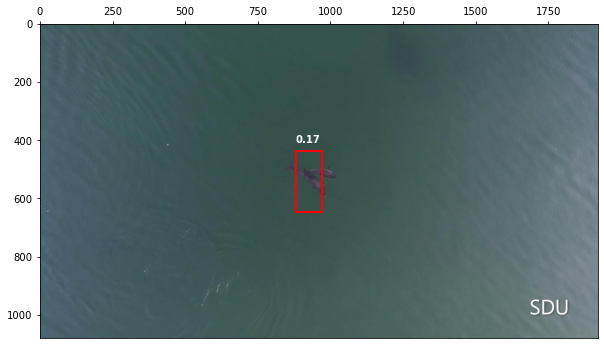

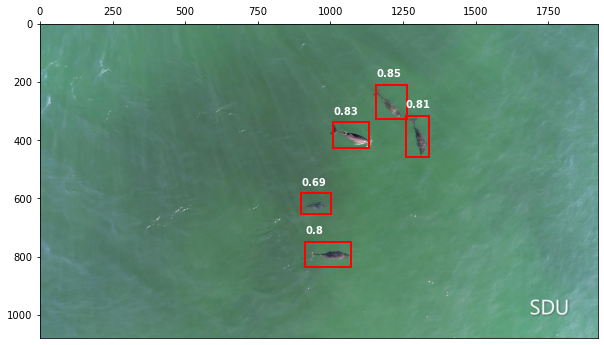

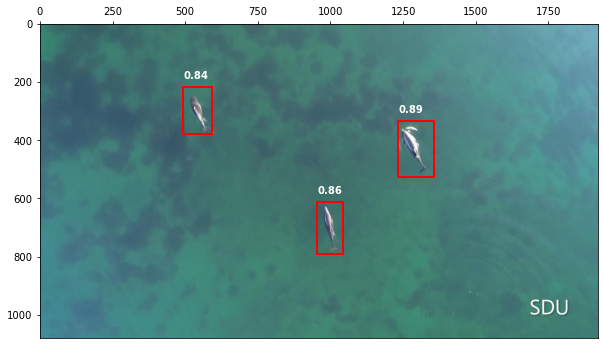

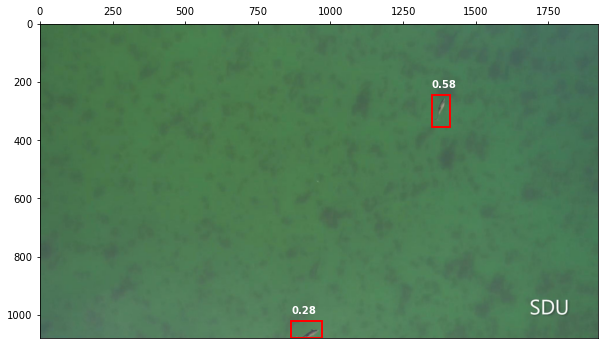

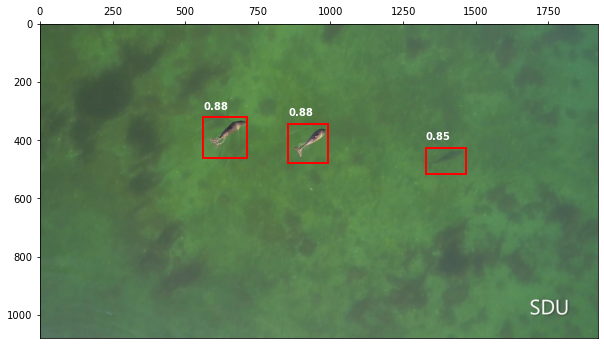

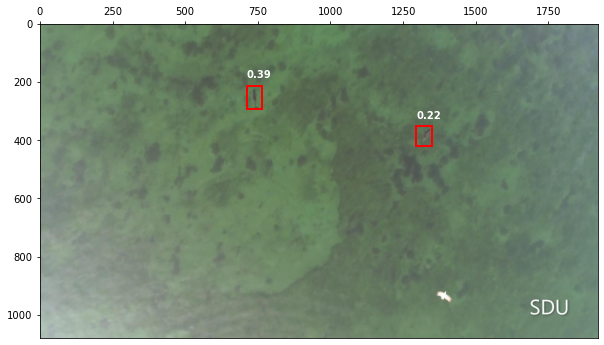

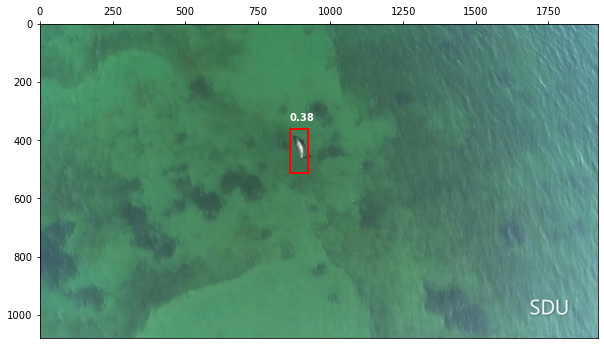

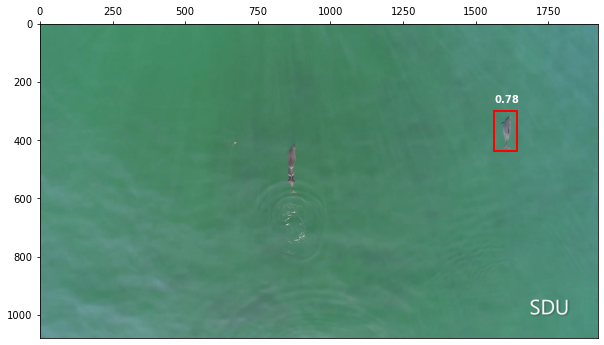

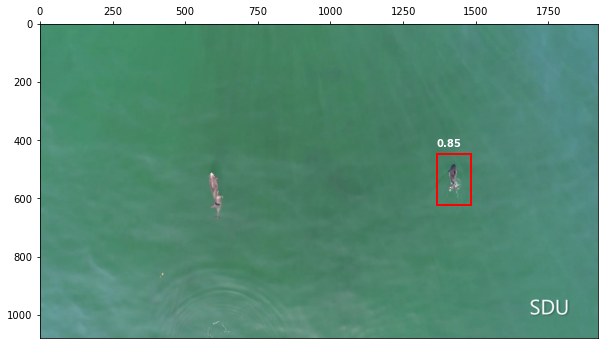

In [38]:


image_dir = 'examples/test_im'
#image_dir = IMAGE_PATH
image_names = os.listdir(image_dir)

PLOT = True
WRITE_TO_FILE = False

json_result = []
start_time = time.time()
print('Processing Images:')
for i in range(len(image_names)):
    #sys.stdout.write('\r Image: {}, Completion: {}%'.format(i+1, round((i+1) / len(image_names)*100)))
    #find path to current image
    image_path = os.path.join(image_dir, image_names[i])
    #load image to numpy array
    image_np = load_image_to_numpy_array(image_path)
    #run inference
    nr_detections, confidence_scores, bboxes, labels = run_inference(image_np)
    #print(bboxes)
    #print(confidence_scores)
    test_image = image_tools.ImageTools(bbox = bboxes, image_tensor = image_np,
                                            label = np.round(confidence_scores,2), figsize=(10,10),
                                            outline = False)
    
    if WRITE_TO_FILE:
        for i in range(nr_detections):
            category_id = int(labels[i])
            bbox = test_image.convert_bb(test_image.bbox)[i]
            bbox = list(bbox.astype('float'))
            score = confidence_scores[i].astype('float')
            print(score)
            json_result.append({
                                "image_id": image_path,
                                "category_id": category_id,
                                "bbox": bbox,
                                "score": score
                                })
    

    #Plotting
    if PLOT:
        test_image.plot_sample()
    
    #sys.stdout.flush()

end_time = time.time()
print('\n','Process complete in {} seconds \n'.format(round(end_time - start_time, 1)))

print('Writing to file...' )
if WRITE_TO_FILE:
    import json
    #print(len(json_result))
    with open('result.json', 'w') as outfile:
        outfile.write('[')
        outfile.write('\n')
        for i in range(len(json_result)):
            json.dump(json_result[i], outfile, separators=(',', ':'))
            if i < len(json_result) - 1:
                outfile.write(',\n')
            else:
                outfile.write('\n')
        outfile.write(']')

print('Writing to file complete.')




In [39]:
print(json_result)

[]
